In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
import string
import validators as val
import seaborn as sb
from yake import KeywordExtractor
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, BatchNormalization, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

en_model = spacy.load('en_core_web_md')

In [2]:
df = pd.read_csv('train.csv',encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


0    4342
1    3271
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='count'>

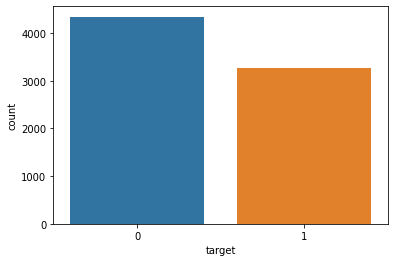

In [3]:
# check target class counts
print(df.target.value_counts())
sb.countplot(x=df.target)

In [4]:
# check for missing data
for col in df.columns:
    if df[col].isnull().mean()>0:
        print(col,df[col].isnull().mean())

keyword 0.008012610009194798
location 0.33272034677525286


In [5]:
# drop location column and fill keyword column with the mode value
df = df[['text','target','keyword']].fillna('nill')

In [6]:
# clean keyword column
def clean_keyword(x):
    x = x.replace('%20',' ')
    tok = en_model(x)
    tok = [str(x.lemma_) for x in tok]
    return ' '.join(tok)

df.keyword = df.keyword.apply(lambda x: clean_keyword(x))

In [7]:
# text cleaning function
# removes numbers, URLs, stopwords, punctuations and twitter handles

def clean_text(text):
    toks = text.split()
    toks = [t for t in toks if not val.url(t) and '@' not in t]
    toks = ' '.join(toks)
    for p in string.punctuation:
        if p not in ('#','@'):
            toks = toks.replace(p,' ')
    
    toks = toks.lower().split()
    toks = [t for t in toks if '@' not in t]
    toks = en_model(" ".join(toks))
    toks = [t for t in toks if str(t)!="'s"]
    toks = [t for t in toks if not t.is_stop and not t.is_digit]
    toks = [str(t) for t in toks if len(str(t))>1]
    return ' '.join(toks)

In [8]:
# original vs cleaned
for _ in range(5):
    i = np.random.randint(0,len(df))
    print('Original : '+df.text[i]+'\nCleaned : '+clean_text(df.text[i]))
    print('target :',df.target[i])
    print()

Original : Have you read this awesome book yet?  The Two Trillion Dollar Meltdown  http://t.co/jPA6sajFE3
Cleaned : read awesome book trillion dollar meltdown
target : 0

Original : Jun 2015. Yemenis search for survivors under the rubble of houses in the old city of SanÛªa following an... http://t.co/11JUzHlgmT
Cleaned : jun yemenis search survivors rubble houses old city sanûªa following
target : 1

Original : A new type of ADHD? Head injuries in children linked to long-term attention problems http://t.co/I4FZ75Utnh
Cleaned : new type adhd head injuries children linked long term attention problems
target : 0

Original : @iamHorsefly hide your kids hide your wife. He's on the loose. I thought I flattened you with a ball ????
Cleaned : hide kids hide wife loose thought flattened ball
target : 0

Original : Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...
Cleaned : madhya pradesh train derailment vi

<AxesSubplot:xlabel='word_count', ylabel='Count'>

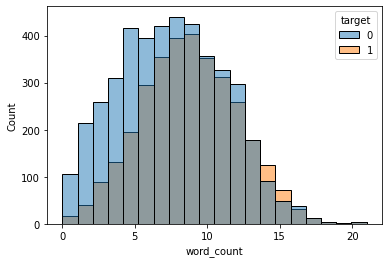

In [9]:
# clean tweet 
df['clean_text'] = df.text.apply(lambda x: clean_text(x))

# get word count of each tweet after cleaning
df['word_count'] = df.clean_text.apply(lambda x: len(x.split()))

# distribution of word count
sb.histplot(data=df,x='word_count',hue='target',bins=20)

In [10]:
# 0.8% of the values in the keyword column are missing.
# impute with the extracted keywords from the cleaned text

for i in df[df.keyword=='nill'].index:
    text = df.clean_text[i]
    ex = KeywordExtractor(n=1)
    kw = ex.extract_keywords(text)
    kw = [k[0] for k in kw if k[0] in df.keyword.unique()]
    if len(kw)>0:
        df.keyword.loc[i] = kw[0]
    else:
        df.keyword.loc[i] = df.keyword.mode()[0]  

C:\Users\BJS\AppData\Local\Temp\ipykernel_19260\1585185542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_19260\1585185542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode()[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_19260\1585185542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\B

C:\Users\BJS\AppData\Local\Temp\ipykernel_19260\1585185542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_19260\1585185542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode()[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_19260\1585185542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\B

In [11]:
# average word count, minimum length and max length of disaster tweets
df[df.target==1].word_count.mean(),df[df.target==1].word_count.min(),df[df.target==1].word_count.max()

(8.857230204830326, 1, 21)

In [12]:
# average word count, minimum length and max length of non-disaster tweets
df[df.target==0].word_count.mean(),df[df.target==0].word_count.min(),df[df.target==0].word_count.max()

(7.66305849838784, 0, 20)

In [13]:
x = df.keyword + ' ' + df.clean_text #cleaned input text
y = df.target #target feature

# get length of max input length
maxlen = 0
for i in x:
    if len(i.split())>maxlen: maxlen=len(i.split())

# split data for training, testing and validation to (70:20:10)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.7)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,train_size=0.7)

In [14]:
# tokenizing and padding

tk = Tokenizer()
tk.fit_on_texts(x)

seq = tk.texts_to_sequences(xtrain)
xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xval)
xval = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xtest)
xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

x_voc = len(tk.word_counts)+1

xtrain.shape,xval.shape,xtest.shape

((5329, 23), (686, 23), (1598, 23))

In [15]:
# load glove vectors
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
 
glove_embeddings = load_glove_model("D:/glove.6B.300d.txt")

Loading Glove Model
400000 words loaded!


In [16]:
# create pretrained embedding matrix
emb = np.zeros((x_voc,300))
for w,idx in tk.word_index.items():
    try: emb[idx] = glove_embeddings[w]
    except: pass

In [17]:
# linear attetion layer
class LinearAttention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)
        super().build(input_shape)
 
    
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context


In [18]:
# classification model

class TweetClassificationModel(tf.keras.models.Model):
    def __init__(self,rnn_units,vocab_size,embedding_weights,emb_dim,**kwargs):
        super().__init__(**kwargs)
        self.rnn_units=rnn_units
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.embedding_weights = embedding_weights
    
    def build(self,input_shape):
        self.emb = Embedding(self.vocab_size,self.emb_dim,weights=[self.embedding_weights])
        self.lstm = LSTM(self.rnn_units,return_sequences=True)
        self.dense = Dense(100,activation='relu')
        self.dropout = Dropout(0.1)
        self.attn = LinearAttention()
        self.out_put = Dense(1,activation='sigmoid')
        self.bn = BatchNormalization()
        super().build(input_shape)
    
    def call(self,x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.attn(x)
        x = self.dense(x)
        x = self.dropout(x)
        x = self.bn(x)
        return self.out_put(x)
    
    def summary(self,input_len):
        x = Input(shape=(input_len,))
        m = Model(x,self.call(x))
        return m.summary()
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'rnn_units':self.rnn_units,
            'vocab_size':self.vocab_size,
            'emb_dim':self.emb_dim,
            'embedding_weights':self.embedding_weights})
        return config
    

    

In [19]:
# initiate and build model

model = TweetClassificationModel(rnn_units=200,
                                vocab_size=x_voc,
                                embedding_weights=emb,
                                emb_dim=300)

model.build((None,maxlen))

model.summary(maxlen)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding (Embedding)       (None, 23, 300)           4332600   
                                                                 
 lstm (LSTM)                 (None, 23, 200)           400800    
                                                                 
 linear_attention (LinearAtt  (None, 200)              223       
 ention)                                                         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                             

In [20]:

loss_func = tf.keras.losses.BinaryCrossentropy() #binary_crossentropy loss
acc_func = tf.keras.metrics.BinaryAccuracy() #binary_accuracy
optimizer = Adam(learning_rate=1e-5) #adam optimizer


In [21]:
@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        pred = model(x, training=True)
        loss = loss_func(y,pred)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients,model.trainable_weights))
    acc_func.update_state(y,pred)
    return loss

@tf.function
def validation_step(x,y):
    pred = model(x, training=False)
    loss = loss_func(y,pred)
    acc = acc_func.update_state(y,pred)
    return loss

In [22]:
def train_model(epochs,trainin_data,validation_data,verbose=False, save_weights=True, filename='best_weights',batch_size=32):
    
    train = tf.data.Dataset.from_tensor_slices(trainin_data).batch(batch_size)
    val = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)
    
    metrics = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}
    
    val_loss, train_loss = 0, 0

    for e in range(epochs):
        if not verbose:
            print(f'Epochs = {e+1}/{epochs}')
        for i,(x,y) in enumerate(tqdm(train,disable=verbose)):
            loss = train_step(x,y)
            train_loss += loss
        
        train_loss = train_loss.numpy()/(i+1)
        train_acc = float(acc_func.result().numpy())
        acc_func.reset_states()
        
        for i,(x,y) in enumerate(val):
            loss = validation_step(x,y)
            val_loss += loss
        
        val_loss = val_loss.numpy()/(i+1)
        val_acc = float(acc_func.result().numpy())
        acc_func.reset_states()
        
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
    
        if save_weights and e+1>1:
            if min(metrics['val_loss'][:-1]) > val_loss:
                model.save_weights(filename)
        
        if not verbose :   
            print(f'train_loss = {np.round(train_loss,4)}  train_acc = {np.round(train_acc,4)}  '\
                  f'val_loss = {np.round(val_loss,4)}  val_acc = {np.round(val_acc,4)}\n')
        
        val_loss = 0
        train_loss = 0
        
    return metrics
        
        
    

In [23]:
# train model and get metrics

metrics = train_model(epochs=30,
                         trainin_data=(xtrain,ytrain),
                         validation_data=(xval,yval))

Epochs = 1/30


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:04<00:00, 37.49it/s]


train_loss = 0.6875  train_acc = 0.6047  val_loss = 0.6657  val_acc = 0.6855

Epochs = 2/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 104.98it/s]


train_loss = 0.5726  train_acc = 0.7106  val_loss = 0.6047  val_acc = 0.7474

Epochs = 3/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.52it/s]


train_loss = 0.5246  train_acc = 0.751  val_loss = 0.5255  val_acc = 0.7729

Epochs = 4/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.81it/s]


train_loss = 0.4918  train_acc = 0.7708  val_loss = 0.4808  val_acc = 0.7786

Epochs = 5/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.79it/s]


train_loss = 0.4735  train_acc = 0.783  val_loss = 0.4644  val_acc = 0.7914

Epochs = 6/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.45it/s]


train_loss = 0.4633  train_acc = 0.7894  val_loss = 0.4557  val_acc = 0.7942

Epochs = 7/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.72it/s]


train_loss = 0.4513  train_acc = 0.7953  val_loss = 0.4476  val_acc = 0.7995

Epochs = 8/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.84it/s]


train_loss = 0.436  train_acc = 0.8032  val_loss = 0.4418  val_acc = 0.7981

Epochs = 9/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 104.91it/s]


train_loss = 0.4274  train_acc = 0.8107  val_loss = 0.4381  val_acc = 0.8038

Epochs = 10/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.18it/s]


train_loss = 0.4162  train_acc = 0.8144  val_loss = 0.4347  val_acc = 0.8109

Epochs = 11/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 104.39it/s]


train_loss = 0.4115  train_acc = 0.8187  val_loss = 0.432  val_acc = 0.8137

Epochs = 12/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.18it/s]


train_loss = 0.404  train_acc = 0.8251  val_loss = 0.4291  val_acc = 0.8151

Epochs = 13/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.38it/s]


train_loss = 0.3962  train_acc = 0.826  val_loss = 0.4275  val_acc = 0.8123

Epochs = 14/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.71it/s]


train_loss = 0.3918  train_acc = 0.8311  val_loss = 0.4254  val_acc = 0.8184

Epochs = 15/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 104.13it/s]


train_loss = 0.3831  train_acc = 0.8337  val_loss = 0.425  val_acc = 0.8198

Epochs = 16/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 104.65it/s]


train_loss = 0.3793  train_acc = 0.838  val_loss = 0.4233  val_acc = 0.8226

Epochs = 17/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.25it/s]


train_loss = 0.3735  train_acc = 0.8419  val_loss = 0.4227  val_acc = 0.8212

Epochs = 18/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.99it/s]


train_loss = 0.3682  train_acc = 0.8417  val_loss = 0.4219  val_acc = 0.8184

Epochs = 19/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.71it/s]


train_loss = 0.3616  train_acc = 0.8475  val_loss = 0.4219  val_acc = 0.8198

Epochs = 20/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.72it/s]


train_loss = 0.3559  train_acc = 0.8507  val_loss = 0.4214  val_acc = 0.8212

Epochs = 21/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 104.59it/s]


train_loss = 0.3469  train_acc = 0.8556  val_loss = 0.4208  val_acc = 0.8198

Epochs = 22/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.98it/s]


train_loss = 0.3449  train_acc = 0.8593  val_loss = 0.4203  val_acc = 0.8198

Epochs = 23/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.18it/s]


train_loss = 0.3401  train_acc = 0.8578  val_loss = 0.4201  val_acc = 0.8226

Epochs = 24/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.92it/s]


train_loss = 0.3361  train_acc = 0.8629  val_loss = 0.4207  val_acc = 0.8226

Epochs = 25/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.78it/s]


train_loss = 0.3296  train_acc = 0.8653  val_loss = 0.4204  val_acc = 0.8226

Epochs = 26/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.98it/s]


train_loss = 0.3271  train_acc = 0.8649  val_loss = 0.4204  val_acc = 0.8226

Epochs = 27/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 105.91it/s]


train_loss = 0.3212  train_acc = 0.8688  val_loss = 0.4212  val_acc = 0.8226

Epochs = 28/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 104.92it/s]


train_loss = 0.3175  train_acc = 0.8692  val_loss = 0.4211  val_acc = 0.8226

Epochs = 29/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.52it/s]


train_loss = 0.3149  train_acc = 0.8711  val_loss = 0.4211  val_acc = 0.8241

Epochs = 30/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 106.11it/s]


train_loss = 0.3088  train_acc = 0.8746  val_loss = 0.4216  val_acc = 0.8226



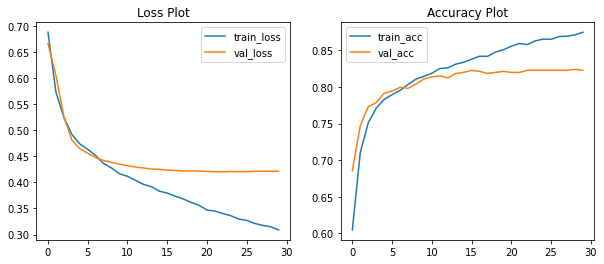

In [24]:
def plot_training_logs(metrics):
    metrics = pd.DataFrame(metrics)
    _,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
    metrics[['train_loss','val_loss']].plot(ax=ax1,title='Loss Plot')
    metrics[['train_acc','val_acc']].plot(ax=ax2,title='Accuracy Plot')
    plt.show()

plot_training_logs(metrics)

In [25]:
model = TweetClassificationModel(rnn_units=200,vocab_size=x_voc,embedding_weights=emb,emb_dim=300)
model.build((None,maxlen))
model.load_weights('best_weights')

def evaluate(x,y):
    pred = model(x,training = False)
    pred = np.round(pred.numpy().flatten())
    print(classification_report(y,pred))
    sb.heatmap(confusion_matrix(y,pred),annot=True,fmt='d',cmap='Blues')
    plt.show()

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       384
           1       0.83      0.75      0.79       302

    accuracy                           0.82       686
   macro avg       0.83      0.82      0.82       686
weighted avg       0.82      0.82      0.82       686



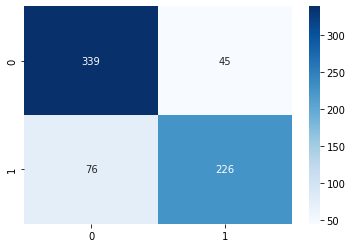

In [26]:
evaluate(xval,yval)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       908
           1       0.82      0.71      0.76       690

    accuracy                           0.81      1598
   macro avg       0.81      0.79      0.80      1598
weighted avg       0.81      0.81      0.80      1598



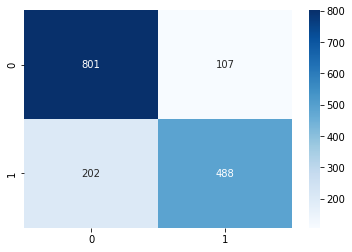

In [27]:
evaluate(xtest,ytest)

fold 1/5
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       868
           1       0.86      0.61      0.71       655

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.77      1523
weighted avg       0.80      0.79      0.78      1523



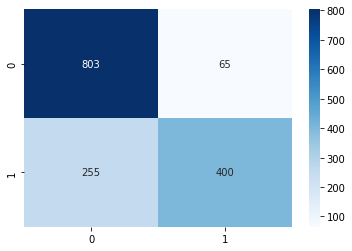

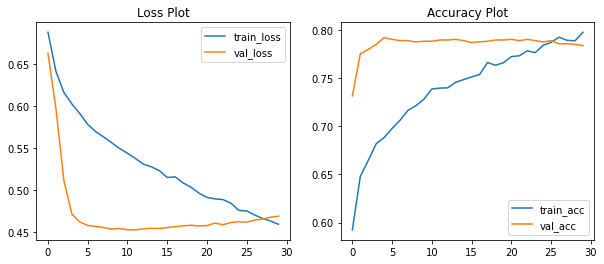


################################################

fold 2/5
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       869
           1       0.72      0.64      0.68       654

    accuracy                           0.74      1523
   macro avg       0.74      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



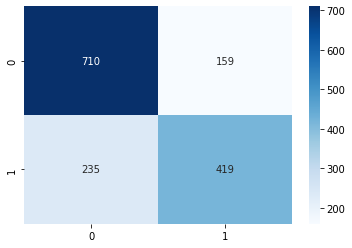

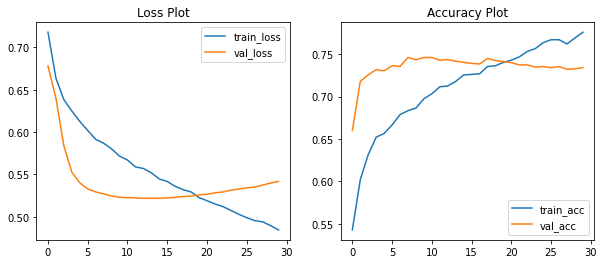


################################################

fold 3/5
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       869
           1       0.73      0.65      0.69       654

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



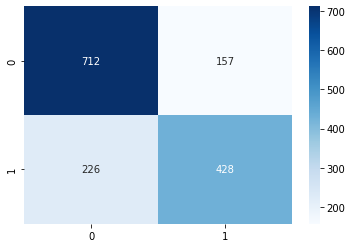

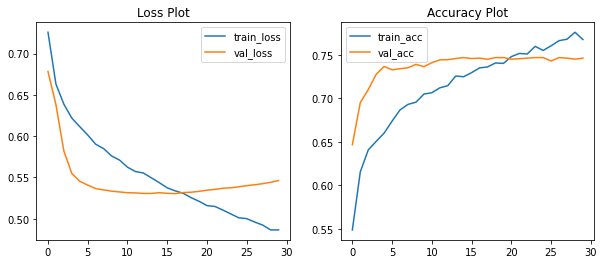


################################################

fold 4/5
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       868
           1       0.78      0.56      0.66       654

    accuracy                           0.75      1522
   macro avg       0.76      0.72      0.73      1522
weighted avg       0.75      0.75      0.74      1522



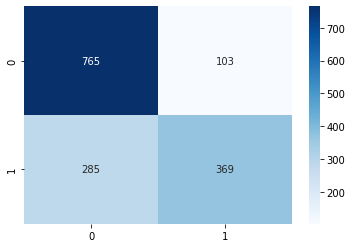

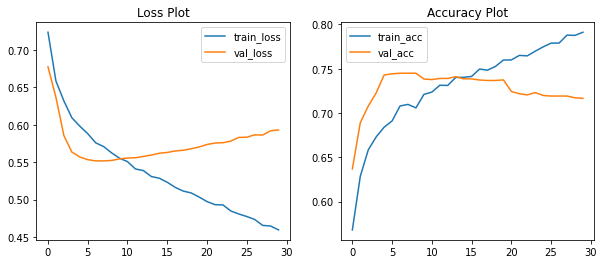


################################################

fold 5/5
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       868
           1       0.85      0.74      0.79       654

    accuracy                           0.83      1522
   macro avg       0.84      0.82      0.83      1522
weighted avg       0.84      0.83      0.83      1522



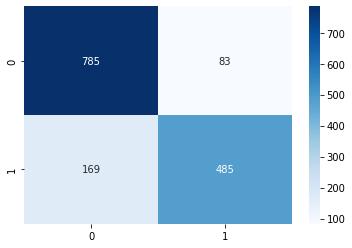

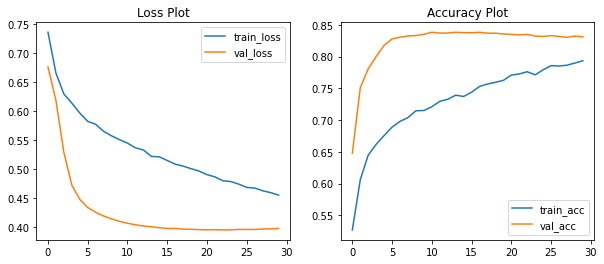


################################################

avg f1-score : 0.7069116710709966
avg accuracy : 0.77184235071005


In [28]:
# cross-validation

n = 5
acc = 0
f1 = 0
sfk = StratifiedKFold(n_splits=n)
sfk.get_n_splits(x,y)
count=1
for train_idx,test_idx in sfk.split(x,y):
    xtrain,xtest = x[train_idx],x[test_idx]
    ytrain,ytest = y[train_idx],y[test_idx]
    
    tk = Tokenizer()
    tk.fit_on_texts(xtrain)

    seq = tk.texts_to_sequences(xtrain)
    xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

    seq = tk.texts_to_sequences(xtest)
    xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

    x_voc = len(tk.word_counts)+1
    
    emb = np.zeros((x_voc,300))
    for w,idx in tk.word_index.items():
        try: emb[idx] = glove_embeddings[w]
        except: pass
    
    model = TweetClassificationModel(rnn_units=200,
                                vocab_size=x_voc,
                                embedding_weights=emb,
                                emb_dim=300)

    model.build((None,maxlen))
    
    loss_func = tf.keras.losses.BinaryCrossentropy()
    acc_func = tf.keras.metrics.BinaryAccuracy()
    optimizer = Adam(learning_rate=1e-5)
    
    @tf.function
    def train_step(x,y):
        with tf.GradientTape() as tape:

            pred = model(x, training=True)

            loss = loss_func(y,pred)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients,model.trainable_weights))
        acc_func.update_state(y,pred)
        return loss

    @tf.function
    def validation_step(x,y):
        pred = model(x, training=False)
        loss = loss_func(y,pred)
        acc = acc_func.update_state(y,pred)
        return loss
    
    print(f'fold {count}/{n}')
    metrics = train_model(epochs=30,
                         trainin_data=(xtrain,ytrain),
                         validation_data=(xtest,ytest),
                         verbose=True, filename='fold_best_weights')
    
    model.load_weights('fold_best_weights')
    
    evaluate(xtest,ytest)
    plot_training_logs(metrics)
    
    pred = model(xtest,training=False)
    pred = np.round(pred.numpy().flatten())
    
    f1 += f1_score(ytest,pred)
    acc += accuracy_score(ytest,pred)
    
    print("\n################################################\n")
    
    count+=1
    
print('avg f1-score :',f1/n)
print('avg accuracy :',acc/n)